# Neural Network
### Mathematical Notation:

$$z = \mathbf{w} \mathbf{x} + b$$
$$a = f(z)$$


In [58]:
import requests, os, gzip
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
mnist_address = [
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/t10k-images-idx3-ubyte.gz",
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/t10k-labels-idx1-ubyte.gz",
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/train-images-idx3-ubyte.gz",
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/train-labels-idx1-ubyte.gz"
]


os.makedirs("mnist_data", exist_ok=True)
mnist_folder = "mnist_data"

def download_mnist(address):
    for address in mnist_address:
        response = requests.get(address)
        file_name = address.split("/")[-1]
        path = os.path.join(mnist_folder, file_name)
        with open(path, "wb") as f:
            f.write(response.content)
download_mnist(mnist_address)

In [ ]:
with gzip.open(os.path.join(mnist_folder, "train-labels-idx1-ubyte.gz"), "rb") as f:
    train_labels = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open(os.path.join(mnist_folder, "train-images-idx3-ubyte.gz"), "rb") as f:
    train_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
with gzip.open(os.path.join(mnist_folder, "t10k-labels-idx1-ubyte.gz"), "rb") as f:
    test_labels = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open(os.path.join(mnist_folder, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    test_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

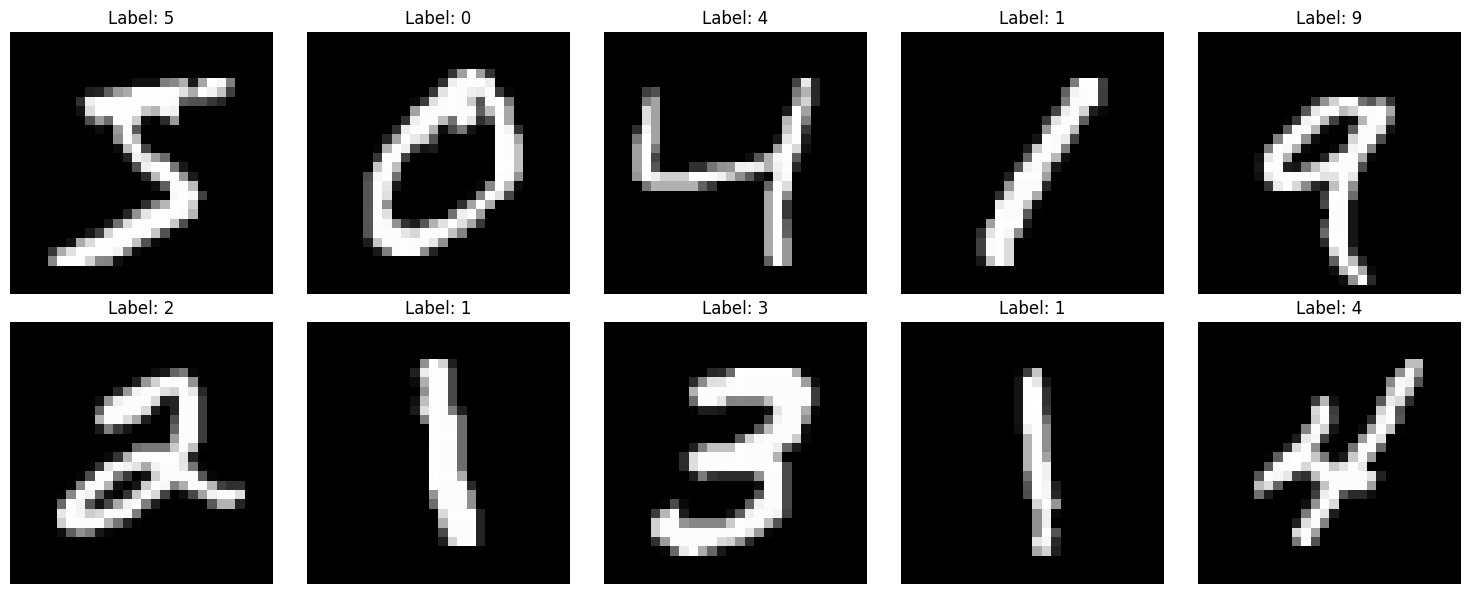

In [64]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax[i//5, i%5].imshow(train_images[i], cmap="gray")
    ax[i//5, i%5].set_title(f"Label: {train_labels[i]}")
    ax[i//5, i%5].axis("off")
plt.tight_layout()
plt.show()



In [67]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

# print(train_images[1])
print (test_labels[0:20])

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [ ]:

scallar = np.array([1])

vector = np.array([1, 2, 3])

matrix = np.array([[1, 2, 3], [4, 5, 6]])

print(scallar.shape)
print(vector.shape)
print(matrix.shape)

In [57]:
input_size = 10
output_size = 4
w = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
# print(w)

x = np.linspace(-2, 2, 20)
print (x)

def relu(x):
    return np.maximum(0, x)

y = relu(x)

# plt.plot(x, y)
# plt.plot(x, x)
# plt.show()

def relu_derivative(input):
    return (input > 0).astype(float)

print (relu_derivative(x))





[-2.         -1.78947368 -1.57894737 -1.36842105 -1.15789474 -0.94736842 -0.73684211 -0.52631579 -0.31578947 -0.10526316  0.10526316  0.31578947  0.52631579  0.73684211  0.94736842  1.15789474  1.36842105  1.57894737  1.78947368  2.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:

from torch._refs import exponential


class LinearLayer():
    def __init__(self, input_size, output_size, activation_enabled=True):
        self.W = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
        self.B = np.zeros(output_size)

        self.activation_enabled = activation_enabled

        self.input_cache = None
        self.preactivation_cache = None

        self.grad_W = np.zeros_like(self.W)
        self.grad_B = np.zeros_like(self.B)


    def relu_activation(self, input):
        return np.maximum(0, input)

    def relu_derivative(self, input):
        return (input > 0).astype(float)
        
    def forward(self, input):
        self.input_cache = input
        self.preactivation_cache = np.dot(self.W, self.input_cache) + self.B
        # print ("input_cache", self.input_cache.shape)
        # print ("output_cache", self.preactivation_cache.shape)
        if self.activation_enabled:
            output = self.relu_activation(self.preactivation_cache)
        else:
            output = self.preactivation_cache
        return output
    def backpropagation(self, grad_output):
        if self.activation_enabled:
            grad = self.relu_derivative(self.preactivation_cache) * grad_output
        else:
            grad = grad_output

        self.grad_W = np.outer(grad, self.input_cache)
        self.grad_B = grad

        grad_input = np.dot(self.W.T, grad)
        return grad_input
    def update_parameters(self, learning_rate):
        self.W -= learning_rate * self.grad_W
        self.B -= learning_rate * self.grad_B







class NumpyFullyConnectedNetwork():
    def __init__(self):
        self.layers = []
        self.layers.append(LinearLayer(28 * 28, 196, True))
        self.layers.append(LinearLayer(196, 32, True))
        self.layers.append(LinearLayer(32, 10, False))
    def softmax(self, input):
        exponential = input - np.max(input)
        exponential = np.exp(exponential)
        return exponential / np.sum(exponential)
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return self.softmax(input)
    def backpropagation(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backpropagation(grad_output)
    def cross_entropy_loss(self, output, target):
        epsilon = 1e-10
        return -np.sum(target * np.log(output + epsilon))
    def update_parameters(self, learning_rate):
        for layer in self.layers:
            layer.update_parameters(learning_rate)

print (train_images[0].shape)
train_images_flat = train_images.reshape(-1, 28*28)
# print (train_images_flat[0])
train_images_flat_scale = (train_images_flat / 255.0) - 0.5 
# print (train_images_flat_scale[0].shape)



numpy_net = NumpyFullyConnectedNetwork()
output = numpy_net.forward(train_images_flat_scale[0])
print (output)
print (np.argmax(output))


training_loop = tqdm(range(60000), desc="Training")

learning_rate = 0.01    
losses = []

for l in training_loop:
    output = numpy_net.forward(train_images_flat_scale[l])
    target = np.zeros(10)
    target[train_labels[l]] = 1
    loss = numpy_net.cross_entropy_loss(output, target)
    losses.append(loss)
    grad_output = output - target
    # print (grad_output)
    # print(output)
    # print(target)
    numpy_net.backpropagation(grad_output)
    numpy_net.update_parameters(learning_rate)
    training_loop.set_description(f"Training loss: {loss}")










(28, 28)
[0.04782793 0.05225621 0.17401366 0.09937059 0.11100516 0.09075244 0.18848552 0.05154349 0.08810991 0.09663508]
6


Training loss: 0.5014603239837033:   6%|██▎                                  | 3846/60000 [00:07<01:43, 543.29it/s]

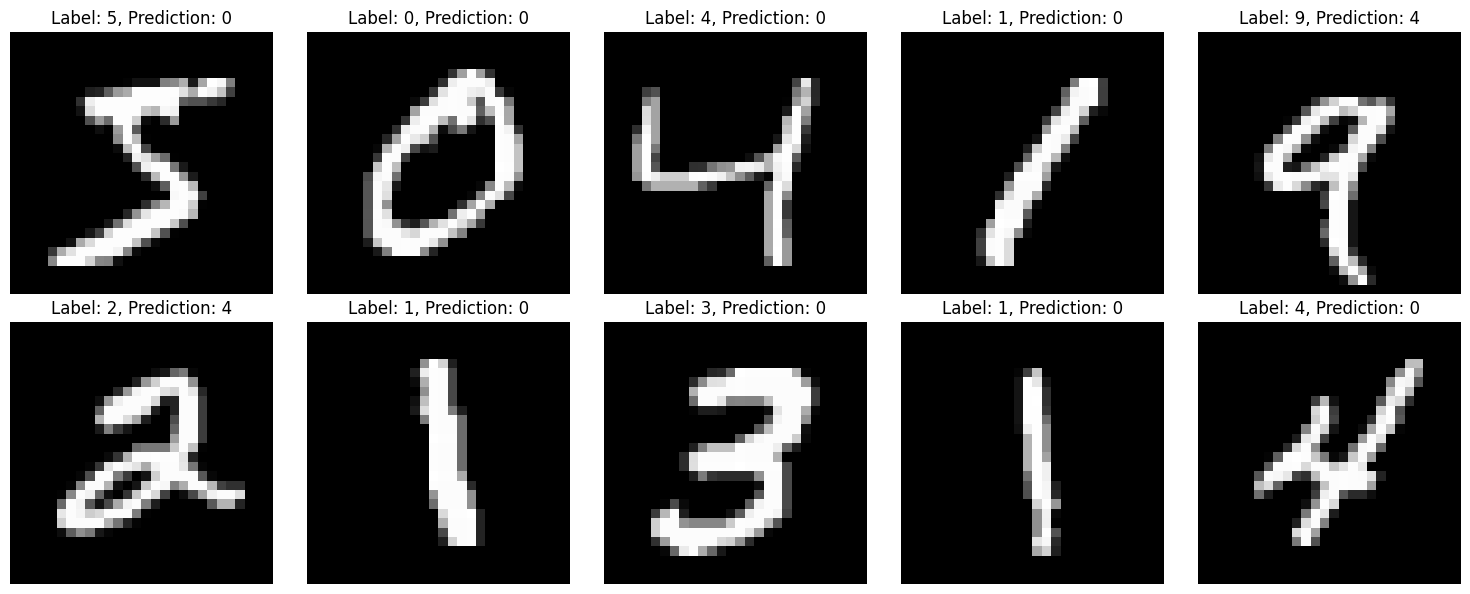

In [47]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    output = numpy_net.forward(train_images_flat_scale[i])
    prediction = np.argmax(output)
    ax[i//5, i%5].imshow(train_images[i], cmap="gray")
    ax[i//5, i%5].set_title(f"Label: {train_labels[i]}, Prediction: {prediction}")
    ax[i//5, i%5].axis("off")
plt.tight_layout()
plt.show()



# Fully connected network

https://adamharley.com/nn_vis/mlp/3d.html

# Membuat Neural Network menggunakan pytorch

In [ ]:
## Batch training

# Convolutional Neural Network

https://adamharley.com/nn_vis/cnn/3d.html